In [1]:
import os 
os.chdir("/nas/ucb/oliveradk/diverse-gen/")
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [2]:
import json
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
# import optuna

# def define_triangle_search_space(trial):
#     """
#     Define a search space for points in right triangle above y=x using Optuna.
    
#     Args:
#         trial: Optuna trial object
#     Returns:
#         Tuple (x, y) representing a point in the triangle
#     """
#     # First sample y uniformly
#     y = trial.suggest_float("y", 0.0, 1.0)
    
#     # Then sample x uniformly between 0 and y
#     x = trial.suggest_float("x", 0.0, 1.0)

#     x = x * (y / 2)
    
#     return x

# # Example usage with visualization
# n_trials = 210 # Adjust this for desired density
# sampler = optuna.samplers.GridSampler(
#     search_space={"x": np.linspace(0, 1, 10), "y": np.linspace(0, 1, 20)}
# )
# study = optuna.create_study(sampler=sampler)

# study.optimize(define_triangle_search_space, n_trials=n_trials)  # Dummy objective function

# # Extract points from study
# points = np.array([[trial.value, trial.params['y']] 
#                   for trial in study.trials])

# # Plotting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# # Plot the points
# ax1.scatter(points[:, 0], points[:, 1], alpha=0.6)
# ax1.set_title('Sampled Points (Optuna)')
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')
# ax1.axis('equal')
# ax1.grid(True)

# # Plot y-value histogram
# ax2.hist(points[:, 1], bins=30, orientation='horizontal')
# ax2.set_ylabel('Y')
# ax2.set_xlabel('Count')
# ax2.set_title('Y-value Distribution')

# plt.tight_layout()
# plt.show()

# # Print number of points
# print(f"Number of points: {len(points)}")

In [4]:
OUT_DIR = Path("output/mix_rate_lb_sweep/2025-02-20_10-44-26") #  2025-02-19_03-34-58 2025-02-19_12-18-14
RESULTS_DIR = Path("results/mix_rate_lb_sweep")
os.makedirs(RESULTS_DIR, exist_ok=True)

In [5]:
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]
DATASETS = ["toy_grid", "fmnist_mnist", "cifar_mnist", "waterbirds"]

In [6]:
def get_study_name(ds_name, mix_rate):
    return f"{ds_name}_{mix_rate}"

In [7]:
# so right now I want to do some exploratory analysis
# for example, for a given dataset and mix rate, plot the max source acc counter grid 
# load all metrics in output/cc_mix_rate_lower_bound_sweep into a dataframe 
results = []
for study_dir in Path(OUT_DIR).iterdir():
    if not study_dir.is_dir():
        continue
    for exp_dir in study_dir.iterdir():
        if not exp_dir.is_dir():
            continue
        metric_file = exp_dir / "metrics.json"
        config_file = exp_dir / "config.yaml"
        if not metric_file.exists(): 
            print(f"No metrics file found for {exp_dir}")
            continue
        with open(metric_file, "r") as f:
            metrics = json.load(f)
        with open(config_file, "r") as f:
            config = yaml.safe_load(f)
        
        min_val_loss_idx = np.argmin(metrics["val_loss"])

        min_val_loss = metrics["val_loss"][min_val_loss_idx]

        source_acc_0 = metrics["val_source_acc_0"][min_val_loss_idx]
        source_acc_1 = metrics["val_source_acc_1"][min_val_loss_idx]
        mean_source_acc = np.mean([source_acc_0, source_acc_1])
        max_source_acc = max(source_acc_0, source_acc_1)

        source_loss = metrics["val_source_loss"][min_val_loss_idx]

        target_acc_0 = metrics["val_target_acc_0"][min_val_loss_idx]
        target_acc_1 = metrics["val_target_acc_1"][min_val_loss_idx]
        max_target_acc = max(target_acc_0, target_acc_1)

        test_acc_0 = metrics["test_acc_0"][min_val_loss_idx]
        test_acc_1 = metrics["test_acc_1"][min_val_loss_idx]
        max_test_acc = max(test_acc_0, test_acc_1)

        test_acc_alt_0 = metrics["test_acc_alt_0"][min_val_loss_idx]
        test_acc_alt_1 = metrics["test_acc_alt_1"][min_val_loss_idx]
        max_test_acc_alt = max(test_acc_alt_0, test_acc_alt_1)

        multi_label_test_acc = np.mean([max_test_acc, max_test_acc_alt])
        
       
        # Create a dictionary for each experiment
        result_dict = {
            'dataset': config["dataset"],
            'mix_rate': config["mix_rate"],
            'mix_rate_lb': config["mix_rate_lower_bound"],
            'mix_rate_lb_01': config["mix_rate_lower_bound_01"],
            'mix_rate_lb_10': config["mix_rate_lower_bound_10"],
            'source_acc': mean_source_acc,
            'max_source_acc': max_source_acc,
            'target_acc': max_target_acc,
            'test_acc': max_test_acc,
            'multi_label_test_acc': multi_label_test_acc,
            'source_loss': source_loss,
            'study_dir': str(study_dir),
            'exp_dir': str(exp_dir)
        }
        results.append(result_dict)

df = pd.DataFrame(results)
df.to_csv(RESULTS_DIR / "mix_rate_lb_sweep_results.csv", index=False)

In [8]:
df = pd.read_csv(RESULTS_DIR / "mix_rate_lb_sweep_results.csv")

In [9]:
import matplotlib
def plot_mix_rate_accuracy_grid(df, datasets, mix_rates, vmins=None, vmaxs=None, acc_metric="source_acc",
                                invert=False, log_scale=False):
    # Handle default vmin/vmax values
    if vmins is None:
        # compute min for each dataset 
        vmins = {dataset: df[df['dataset'] == dataset][acc_metric].min() for dataset in datasets}
    elif isinstance(vmins, (int, float)):
        vmins = {dataset: vmins for dataset in datasets}
        
    if vmaxs is None:
        vmaxs = {dataset: df[df['dataset'] == dataset][acc_metric].max() for dataset in datasets}
    elif isinstance(vmaxs, (int, float)):
        vmaxs = {dataset: vmaxs for dataset in datasets}
    
    # Create subplot grid
    n_rows = len(datasets)
    n_cols = len(mix_rates)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    
    # Store scatter plot objects for colorbars
    scatter_plots = {}

    cmap = 'viridis_r' if invert else 'viridis'
    
    # Iterate through datasets and mix rates
    for i, dataset in enumerate(datasets):
        for j, mix_rate in enumerate(mix_rates):
            ax = axes[i, j]
            
            # Filter data
            mask = (df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)
            data = df[mask]
            
            if len(data) == 0:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center')
                continue
            
            # Create scatter plot with appropriate normalization
            norm = matplotlib.colors.LogNorm(vmin=vmins[dataset], vmax=vmaxs[dataset]) if log_scale else None
            
            # Create scatter plot
            scatter = ax.scatter(
                data['mix_rate_lb_01'], 
                data['mix_rate_lb_01'] + data['mix_rate_lb_10'], 
                c=data[acc_metric],
                cmap=cmap,
                norm=norm,
                vmin=None if log_scale else vmins[dataset],
                vmax=None if log_scale else vmaxs[dataset],
                s=50  # Reduced point size for grid layout
            )
            
            # Store scatter plot object for colorbar
            if j == n_cols - 1:  # Only for last column
                scatter_plots[dataset] = scatter
            
            # Add labels
            if i == len(datasets)-1:  # Only bottom row
                ax.set_xlabel('Mix Rate LB 01')
            if j == 0:  # Only leftmost column
                ax.set_ylabel('Mix Rate LB Sum')
            
            # Add title for top row only
            if i == 0:
                ax.set_title(f'Mix Rate: {mix_rate}')
            
            # Add dataset name on right side
            if j == len(mix_rates)-1:
                ax.text(1.02, 0.5, dataset, rotation=-90,
                       transform=ax.transAxes, va='center')
    
    # Add colorbars for each dataset on the right
    for i, (dataset, scatter) in enumerate(scatter_plots.items()):
        cax = fig.add_axes([0.92, 0.75 - (i * 0.2), 0.02, 0.15])  # [x, y, width, height]
        cbar = plt.colorbar(scatter, cax=cax)
        cbar.set_label(f'{dataset}\nMax Source Accuracy')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbars
    plt.show()

In [11]:
erm_source_accs = df[df["mix_rate_lb"] == 0.0].groupby('dataset')['source_acc'].mean()
erm_source_accs_std = df[df["mix_rate_lb"] == 0.0].groupby('dataset')['source_acc'].std()

/tmp/ipykernel_639004/3451201654.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbars


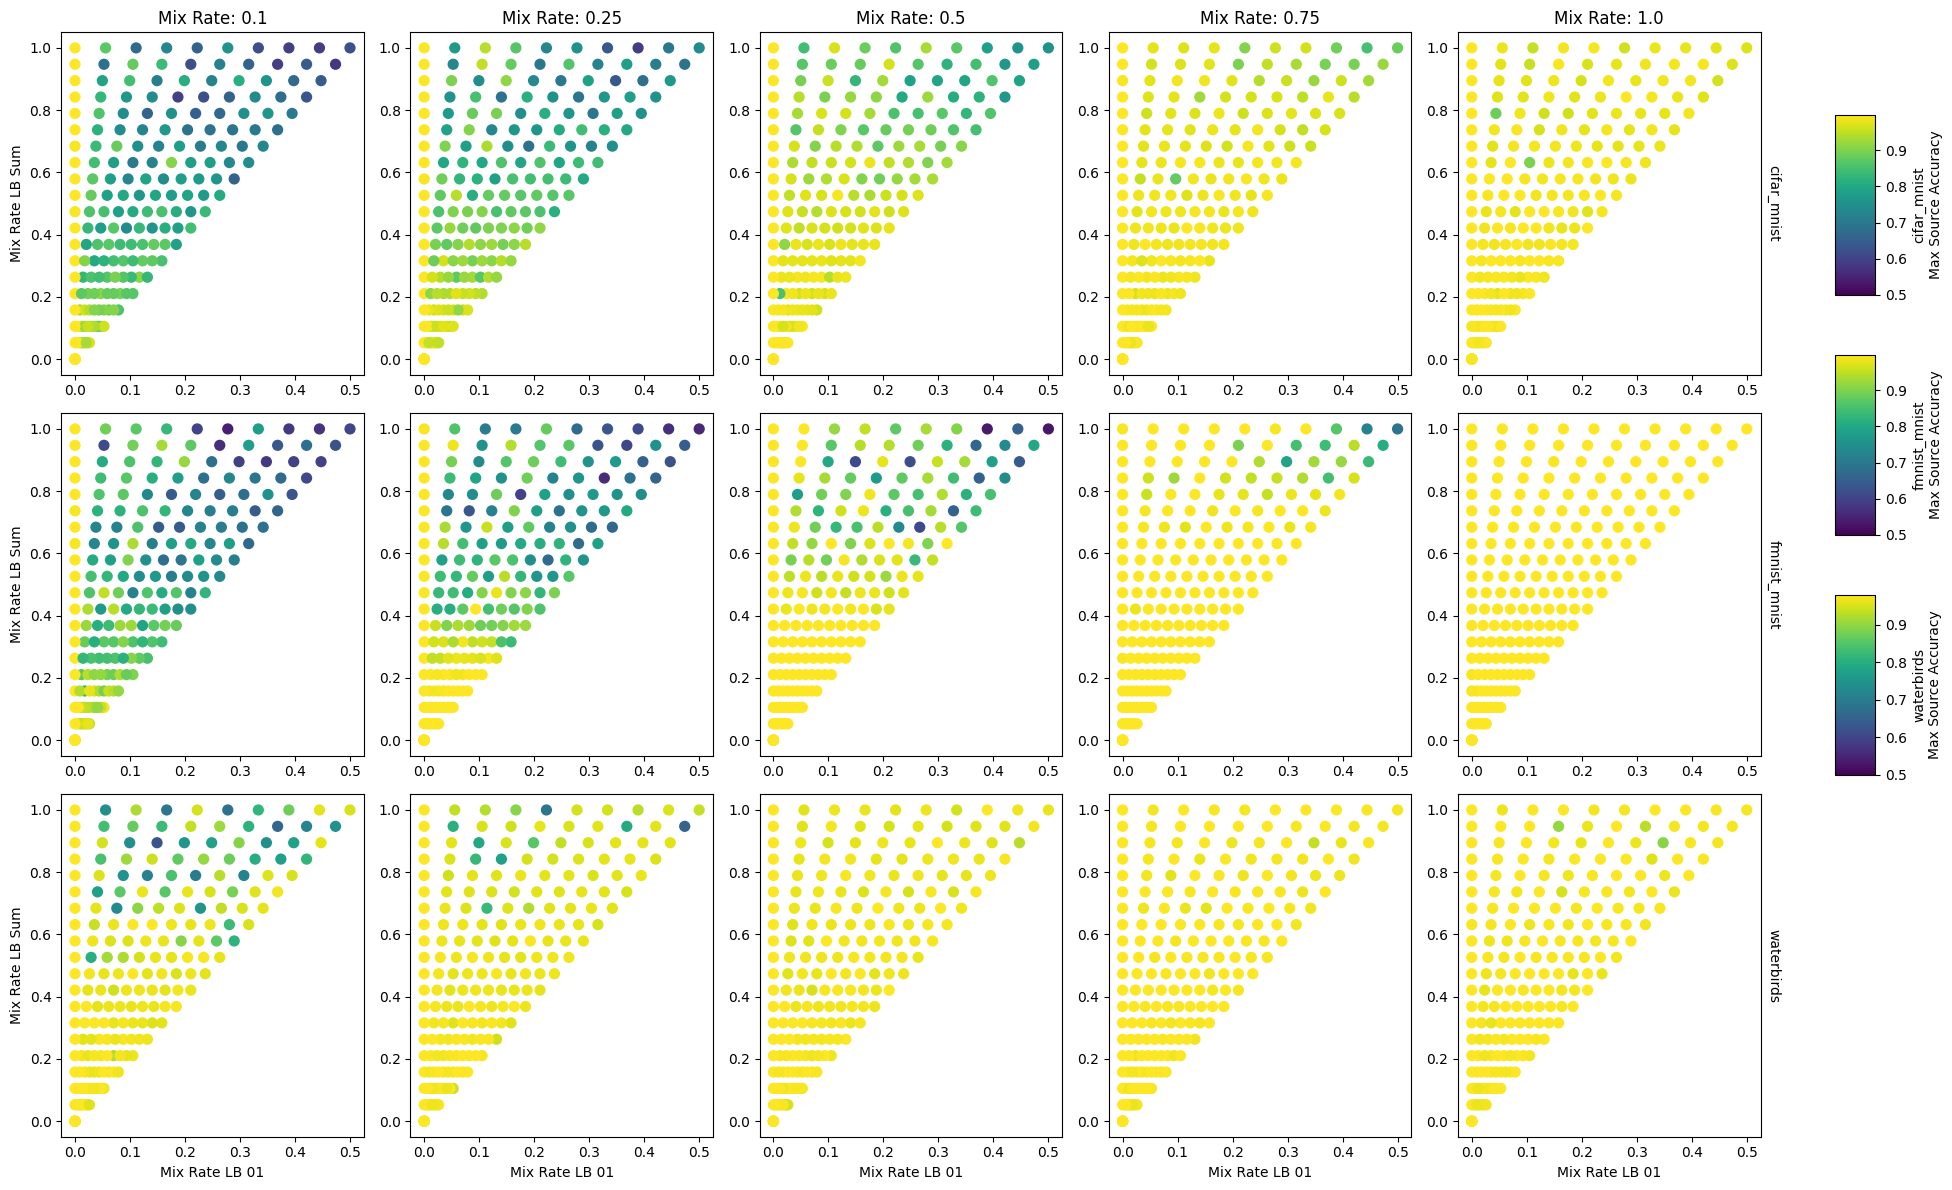

In [13]:
plot_mix_rate_accuracy_grid(
    df,
    acc_metric="source_acc",
    datasets=['cifar_mnist', 'fmnist_mnist', 'waterbirds'],
    mix_rates=[0.1, 0.25, 0.5, 0.75, 1.0],
    vmins={'cifar_mnist': 0.5, 'toy_grid': 0.5, 'fmnist_mnist': 0.5, 'waterbirds': 0.5},
    vmaxs={dataset: erm_source_accs[dataset] - erm_source_accs_std[dataset] for dataset in df["dataset"].unique()}
)

In [70]:
erm_test_accs = df[df["mix_rate_lb"] == 0.0].groupby('dataset')['test_acc'].mean()
erm_test_accs_std = df[df["mix_rate_lb"] == 0.0].groupby('dataset')['test_acc'].std()

/tmp/ipykernel_639004/3451201654.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbars


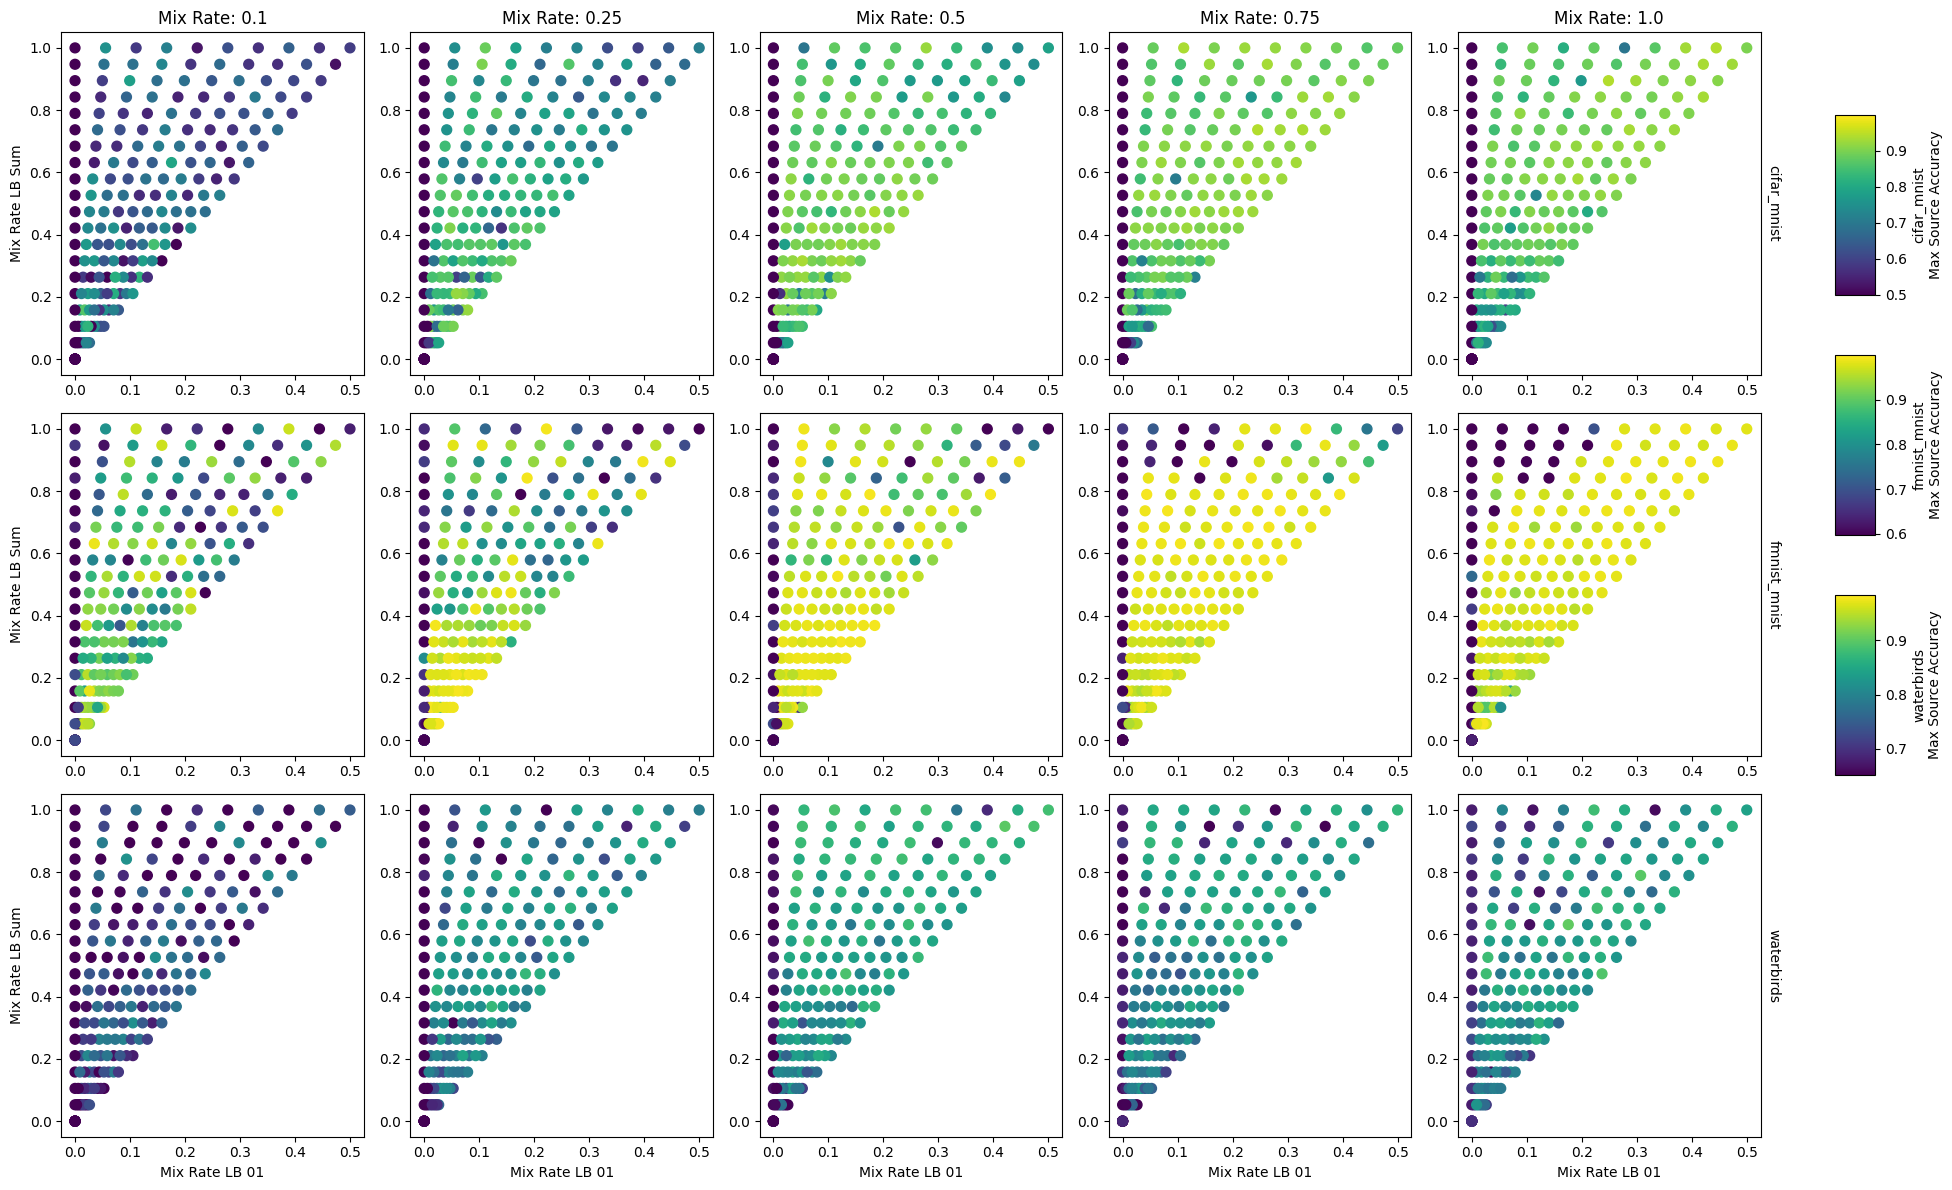

In [71]:
MIN_TEST_ACC = 0.5
plot_mix_rate_accuracy_grid(
    df,
    acc_metric="test_acc",
    datasets=['cifar_mnist', 'fmnist_mnist', 'waterbirds'],
    mix_rates=[0.1, 0.25, 0.5, 0.75, 1.0],
    vmins={dataset: erm_test_accs[dataset] for dataset in df["dataset"].unique()},
    vmaxs={dataset: erm_source_accs[dataset] for dataset in df["dataset"].unique()}
)

In [82]:
def find_optimal_point_on_density(density, target_value, x_range=(0, 0.5), y_range=(0, 1), n_points=100):
    """
    Find point with density >= target_value that maximizes x * (y/2).
    
    Args:
        density: 2D masked array containing density values
        target_value: float, the minimum density value required
        x_range: tuple (min_x, max_x) for the x coordinate range
        y_range: tuple (min_y, max_y) for the y coordinate range
        n_points: int, number of points in each dimension of the grid
        
    Returns:
        tuple (x, y) of optimal point coordinates
    """
    # Create proper coordinate grids
    x = np.linspace(x_range[0], x_range[1], n_points)
    y = np.linspace(y_range[0], y_range[1], n_points)
    X, Y = np.meshgrid(x, y)
    
    # Create mask for points above threshold and in valid region (y >= 2x)
    valid_mask = (density >= target_value) & (Y >= 2*X)
    
    if not np.any(valid_mask):
        raise ValueError("No points found above target value")
    
    # Calculate objective for each valid point
    objectives = np.ma.masked_array(X * (Y/2), ~valid_mask)
    
    # Find indices of maximum objective
    max_idx = np.unravel_index(objectives.argmax(), objectives.shape)
    
    # Convert indices to coordinates
    optimal_x = X[max_idx]
    optimal_y = Y[max_idx]
    
    return optimal_x, optimal_y

In [83]:
def plot_mix_rate_density_grid(df, datasets, mix_rates, vmins=None, vmaxs=None, acc_metric="source_acc",
                                invert=False, dataset_thresholds: dict[str, float] = None, contour_colors='red'):
    """
    Plot grid of density plots showing max source accuracy distribution for all datasets and mix rates.
    Only shows region where y >= x (upper triangle).
    """
    from scipy.stats import gaussian_kde
    
    # Handle default vmin/vmax values
    if vmins is None:
        vmins = {dataset: df[df['dataset'] == dataset][acc_metric].min() for dataset in datasets}
    elif isinstance(vmins, (int, float)):
        vmins = {dataset: vmins for dataset in datasets}
        
    if vmaxs is None:
        vmaxs = {dataset: df[df['dataset'] == dataset][acc_metric].max() for dataset in datasets}
    elif isinstance(vmaxs, (int, float)):
        vmaxs = {dataset: vmaxs for dataset in datasets}
    
    # Create subplot grid
    n_rows = len(datasets)
    n_cols = len(mix_rates)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    
    # Store imshow objects for colorbars
    imshow_plots = {}

    cmap = 'viridis_r' if invert else 'viridis'
    optimal_points = {}
    
    # Iterate through datasets and mix rates
    for i, dataset in enumerate(datasets):
        for j, mix_rate in enumerate(mix_rates):
            ax = axes[i, j]
            
            # Filter data
            mask = (df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)
            data = df[mask]
            
            if len(data) == 0:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center')
                continue
            
            # Create grid for density estimation
            x = data['mix_rate_lb_01']
            y = data['mix_rate_lb_01'] + data['mix_rate_lb_10']
            z = data[acc_metric]
            
            # Create grid
            xi = np.linspace(x.min(), x.max(), 100)
            yi = np.linspace(y.min(), y.max(), 100)
            xi, yi = np.meshgrid(xi, yi)
            
            # Create mask for upper triangle (y >= x)
            triangle_mask = yi >= xi * 2
            
            # Calculate weighted average source accuracy for each grid point
            zi = np.zeros_like(xi)
            for idx in range(len(x)):
                weights = np.exp(-0.5 * (((xi - x.iloc[idx])/0.05)**2 + 
                                       ((yi - y.iloc[idx])/0.05)**2))
                zi += weights * z.iloc[idx]
            zi /= np.sum([np.exp(-0.5 * (((xi - x.iloc[idx])/0.05)**2 + 
                                        ((yi - y.iloc[idx])/0.05)**2))
                         for idx in range(len(x))], axis=0)
            
            # Apply triangle mask
            zi = np.ma.masked_array(zi, ~triangle_mask)

            optimal_x, optimal_y = find_optimal_point_on_density(zi, dataset_thresholds[dataset], 
                                                                x_range=(x.min(), x.max()),
                                                                y_range=(y.min(), y.max()))
            optimal_points[(dataset, mix_rate)] = (optimal_x, optimal_y)
            
            # Create density plot
            im = ax.imshow(zi, extent=[x.min(), x.max(), y.min(), y.max()],
                          origin='lower', aspect='auto', cmap=cmap,
                          vmin=vmins[dataset], vmax=vmaxs[dataset])
            
            # Add optimal point
            ax.scatter(optimal_x, optimal_y, color='red', marker='x')
            
            # Store imshow object for colorbar
            if j == n_cols - 1:
                imshow_plots[dataset] = im
            
             # Create density plot
            im = ax.imshow(zi, extent=[x.min(), x.max(), y.min(), y.max()],
                          origin='lower', aspect='auto', cmap=cmap,
                          vmin=vmins[dataset], vmax=vmaxs[dataset])
            
            # Add contour if threshold is specified
            # Add contour lines if levels specified
            if dataset_thresholds is not None:
                levels = [dataset_thresholds[dataset]]
                cs = ax.contour(xi, yi, zi, levels=levels,
                              colors=contour_colors, linewidths=1,
                              extent=[x.min(), x.max(), y.min(), y.max()])
                ax.clabel(cs, inline=True, fmt='%.2f')
            
            # Add labels
            if i == len(datasets)-1:
                ax.set_xlabel('Mix Rate LB 01')
            if j == 0:
                ax.set_ylabel('Mix Rate LB Sum')
            
            # Add title for top row only
            if i == 0:
                ax.set_title(f'Mix Rate: {mix_rate}')
            
            # Add dataset name on right side
            if j == len(mix_rates)-1:
                ax.text(1.02, 0.5, dataset, rotation=-90,
                       transform=ax.transAxes, va='center')
    
    # Add colorbars for each dataset on the right
    for i, (dataset, im) in enumerate(imshow_plots.items()):
        cax = fig.add_axes([0.92, 0.75 - (i * 0.2), 0.02, 0.15])
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label(f'{dataset}\nMax Source Accuracy')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()
    return optimal_points


/tmp/ipykernel_639004/2533637839.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


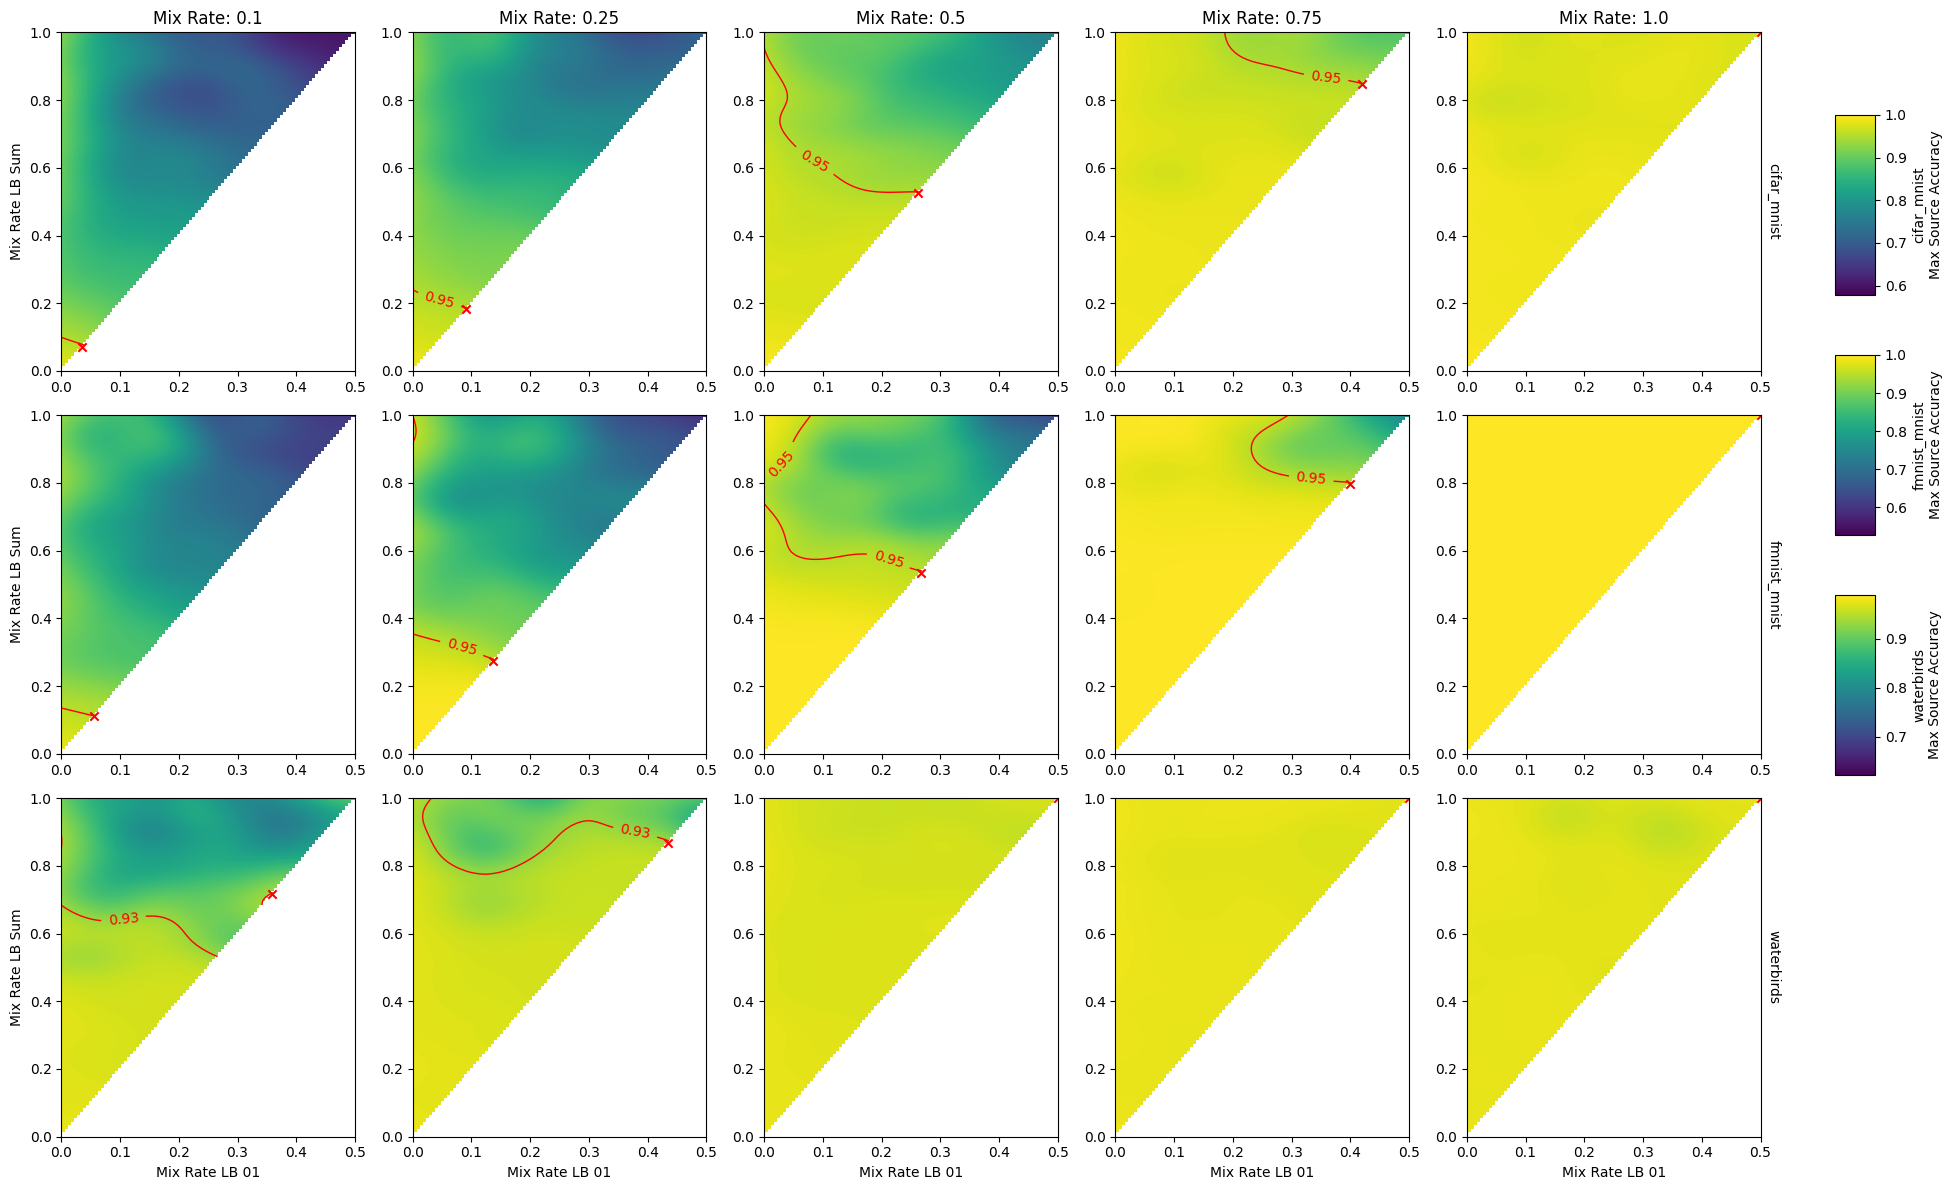

In [84]:
optimal_points = plot_mix_rate_density_grid(
    df,
    acc_metric="source_acc",
    invert=False,
    datasets=['cifar_mnist', 'fmnist_mnist', 'waterbirds'],
    mix_rates=[0.1, 0.25, 0.5, 0.75, 1.0],
    # vmins={'cifar_mnist': 0.5, 'fmnist_mnist': 0.5, 'waterbirds': 0.5},
    # vmaxs={dataset: erm_source_accs[dataset] - (STDS * erm_source_accs_std[dataset]) for dataset in df["dataset"].unique()},
    dataset_thresholds={dataset: 0.95 * erm_source_accs[dataset] for dataset in df["dataset"].unique()},
    contour_colors=['red']
)

In [85]:
optimal_points

{('cifar_mnist', 0.1): (0.03535353535353536, 0.07070707070707072),
 ('cifar_mnist', 0.25): (0.09090909090909091, 0.18181818181818182),
 ('cifar_mnist', 0.5): (0.26262626262626265, 0.5252525252525253),
 ('cifar_mnist', 0.75): (0.4191919191919192, 0.8484848484848485),
 ('cifar_mnist', 1.0): (0.5, 1.0),
 ('fmnist_mnist', 0.1): (0.05555555555555556, 0.11111111111111112),
 ('fmnist_mnist', 0.25): (0.13636363636363638, 0.27272727272727276),
 ('fmnist_mnist', 0.5): (0.2676767676767677, 0.5353535353535354),
 ('fmnist_mnist', 0.75): (0.398989898989899, 0.797979797979798),
 ('fmnist_mnist', 1.0): (0.5, 1.0),
 ('waterbirds', 0.1): (0.3585858585858586, 0.7171717171717172),
 ('waterbirds', 0.25): (0.43434343434343436, 0.8686868686868687),
 ('waterbirds', 0.5): (0.5, 1.0),
 ('waterbirds', 0.75): (0.5, 1.0),
 ('waterbirds', 1.0): (0.5, 1.0)}

ok thoughts based on conversation with Ben 


- maybe do grid search so averaging over points makes more sense 
- instead of picking a fixed point, could use all the models in a weighted ensemble, weight exponentially decaying by standard deviations away from ERM


ok and then the "seed" population can be in some sense informed by the prior (so can make the seeds uniform)

- with an automatic procedure, could also test performance on datasets with randomly sampled mix rates (but in practice we could just do 0.1-1 at intervals of 0.1) 
- the key is using no human in the loop who knows about the mix rate